In [27]:
import numpy as np


In [28]:
z_mean = 20
noise_param = 0.2
time_steps = 2000
period = 20
A = 5

z_temp = z_mean + A * np.sin(2 * np.pi * np.arange(time_steps) / period) + np.random.normal(loc=0, scale=noise_param, size=time_steps)

In [29]:
# Helper function to update state using dEWMA
def update_node_state_dewma(measured_value, last_state_value, last_rate_of_change, delta_t, beta_1, beta_2):
    x1 = beta_1 * measured_value + (1 - beta_1) * (last_state_value + last_rate_of_change * delta_t)
    x2 = beta_2 * (x1 - last_state_value) / delta_t + (1 - beta_2) * last_rate_of_change
    return x1, x2

In [30]:
import numpy as np

def update_node_state_dewma(measured_value, last_state_value, last_rate_of_change, delta_t, beta_1, beta_2):
    """ Update the estimated state using the dEWMA method. """
    x1 = beta_1 * measured_value + (1 - beta_1) * (last_state_value + last_rate_of_change * delta_t)
    x2 = beta_2 * (x1 - last_state_value) / delta_t + (1 - beta_2) * last_rate_of_change
    return x1, x2

def mse_between_estimate_and_true(oracle_value, estimated_value):
    """ Compute MSE between the oracle's transmitted value and the push-based estimate. """
    return (oracle_value - estimated_value) ** 2

def push_based_system_voi(z_temp, time_steps, threshold, beta_1, beta_2, delta_t):
    last_state_value = 0
    last_rate_of_change = 0
    cumulative_mse = 0
    transmission_count = 0

    # Initialize the oracle's last transmitted value
    oracle_last_transmitted_value = z_temp[0]
    voi_mse_list = []

    for t in range(1, time_steps):
        # Update the state with dEWMA
        measured_value = z_temp[t]
        x1, x2 = update_node_state_dewma(measured_value, last_state_value, last_rate_of_change, delta_t, beta_1, beta_2)

        # Oracle decision (transmit only if VoI > threshold)
        if np.abs(z_temp[t] - oracle_last_transmitted_value) > threshold:
            oracle_transmit = 1  # Oracle transmits
            oracle_last_transmitted_value = z_temp[t]  # Update the last transmitted value

            # Capture the push-based system's estimated value at this oracle transmission point
            mse = mse_between_estimate_and_true(oracle_last_transmitted_value, x1)
            cumulative_mse += mse
            transmission_count += 1
            voi_mse_list.append((t, mse))  # Store time and MSE for analysis

        # Update the estimated state
        last_state_value = x1
        last_rate_of_change = x2

    # Return cumulative MSE, transmission count, and recorded VoI comparison points
    return cumulative_mse, transmission_count, voi_mse_list


Cumulative MSE: 0.0
Total Transmissions (Oracle): 366


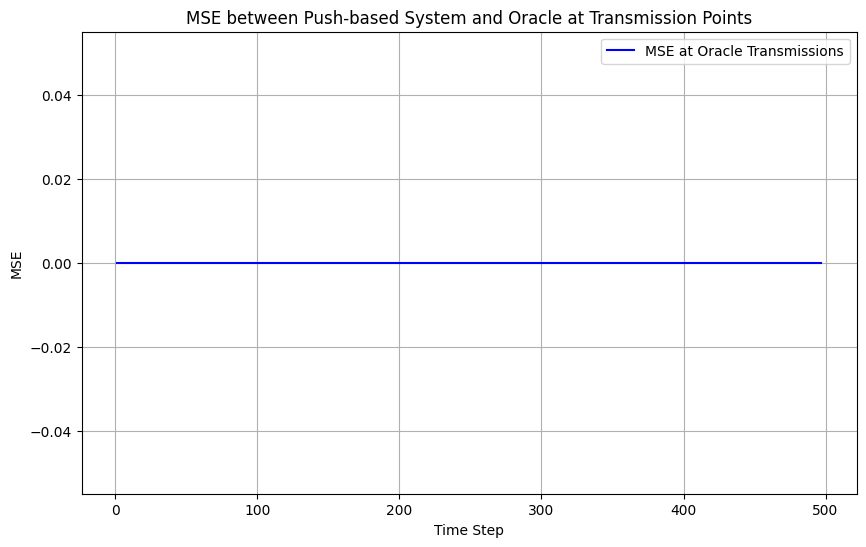

In [31]:
import numpy as np
import matplotlib.pyplot as plt

# Helper function to update the state using dEWMA
def update_node_state_dewma(measured_value, last_state_value, last_rate_of_change, delta_t, beta_1, beta_2):
    x1 = beta_1 * measured_value + (1 - beta_1) * (last_state_value + last_rate_of_change * delta_t)
    x2 = beta_2 * (x1 - last_state_value) / delta_t + (1 - beta_2) * last_rate_of_change
    return x1, x2

# MSE function to compare the oracle's true value and the estimated value
def mse_between_estimate_and_true(oracle_value, estimated_value):
    return (oracle_value - estimated_value) ** 2

# Function to simulate the push-based system with VoI calculation
def push_based_system_voi(z_temp, time_steps, threshold, beta_1, beta_2, delta_t):
    last_state_value = 0
    last_rate_of_change = 0
    cumulative_mse = 0
    transmission_count = 0
    voi_mse_list = []

    # Initialize the oracle's last transmitted value
    oracle_last_transmitted_value = z_temp[0]

    for t in range(1, time_steps):
        # Update the state with dEWMA
        measured_value = z_temp[t]
        x1, x2 = update_node_state_dewma(measured_value, last_state_value, last_rate_of_change, delta_t, beta_1, beta_2)

        # Oracle decision (transmit only if VoI > threshold)
        if np.abs(z_temp[t] - oracle_last_transmitted_value) > threshold:
            oracle_transmit = 1  # Oracle transmits
            oracle_last_transmitted_value = z_temp[t]  # Update the last transmitted value

            # Capture the push-based system's estimated value at this oracle transmission point
            mse = mse_between_estimate_and_true(oracle_last_transmitted_value, x1)
            cumulative_mse += mse
            transmission_count += 1
            voi_mse_list.append((t, mse))  # Store time and MSE for analysis

        # Update the estimated state
        last_state_value = x1
        last_rate_of_change = x2

    return cumulative_mse, transmission_count, voi_mse_list

# Generate realistic test values for z_temp
def generate_signal(time_steps, z_mean, A, period, noise_param):
    t = np.arange(time_steps)
    z_temp = z_mean + A * np.sin(2 * np.pi * t / period) + np.random.normal(loc=0, scale=noise_param, size=time_steps)
    return z_temp

# Parameters
time_steps = 500  # Number of time steps
z_mean = 0  # Mean value of the signal
A = 5  # Amplitude of the signal
period = 50  # Period of the sine wave
noise_param = 1  # Noise level
threshold = 0.5  # Threshold for VoI
beta_1 =1  # dEWMA beta_1
beta_2 = 1  # dEWMA beta_2
delta_t = 1  # Time step for the rate of change

# Generate the signal
z_temp = generate_signal(time_steps, z_mean, A, period, noise_param)

# Run the experiment for the push-based system with VoI calculation
cumulative_mse, transmission_count, voi_mse_list = push_based_system_voi(z_temp, time_steps, threshold, beta_1, beta_2, delta_t)

# Output Results
print(f"Cumulative MSE: {cumulative_mse}")
print(f"Total Transmissions (Oracle): {transmission_count}")

# Plot the MSE over time at the oracle's transmission points
times, mse_values = zip(*voi_mse_list)
plt.figure(figsize=(10, 6))
plt.plot(times, mse_values, label="MSE at Oracle Transmissions", color='blue')
plt.xlabel("Time Step")
plt.ylabel("MSE")
plt.title("MSE between Push-based System and Oracle at Transmission Points")
plt.legend()
plt.grid(True)
plt.show()


Cumulative MSE: 0.0
Total Transmissions (Oracle): 441


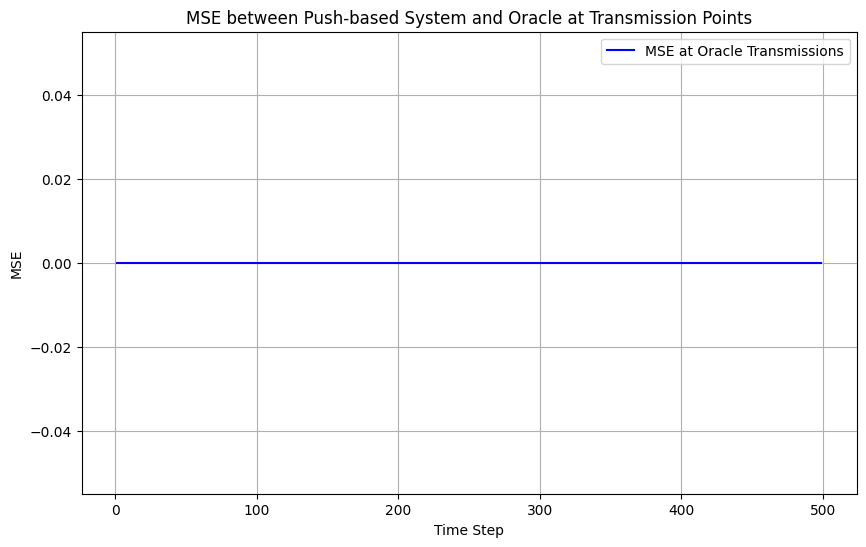

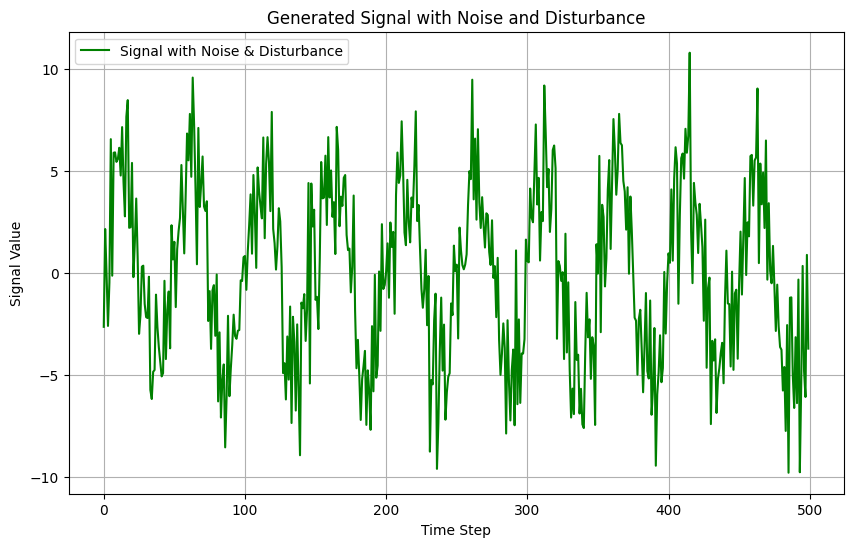

In [33]:
import numpy as np
import matplotlib.pyplot as plt

# Helper function to update the state using dEWMA
def update_node_state_dewma(measured_value, last_state_value, last_rate_of_change, delta_t, beta_1, beta_2):
    x1 = beta_1 * measured_value + (1 - beta_1) * (last_state_value + last_rate_of_change * delta_t)
    x2 = beta_2 * (x1 - last_state_value) / delta_t + (1 - beta_2) * last_rate_of_change
    return x1, x2

# MSE function to compare the oracle's true value and the estimated value
def mse_between_estimate_and_true(oracle_value, estimated_value):
    return (oracle_value - estimated_value) ** 2

# Function to simulate the push-based system with VoI calculation
def push_based_system_voi(z_temp, time_steps, threshold, beta_1, beta_2, delta_t):
    last_state_value = 0
    last_rate_of_change = 0
    cumulative_mse = 0
    transmission_count = 0
    voi_mse_list = []

    # Initialize the oracle's last transmitted value
    oracle_last_transmitted_value = z_temp[0]

    for t in range(1, time_steps):
        # Update the state with dEWMA
        measured_value = z_temp[t]
        x1, x2 = update_node_state_dewma(measured_value, last_state_value, last_rate_of_change, delta_t, beta_1, beta_2)

        # Oracle decision (transmit only if VoI > threshold)
        if np.abs(z_temp[t] - oracle_last_transmitted_value) > threshold:
            oracle_transmit = 1  # Oracle transmits
            oracle_last_transmitted_value = z_temp[t]  # Update the last transmitted value

            # Capture the push-based system's estimated value at this oracle transmission point
            mse = mse_between_estimate_and_true(oracle_last_transmitted_value, x1)
            cumulative_mse += mse
            transmission_count += 1
            voi_mse_list.append((t, mse))  # Store time and MSE for analysis

        # Update the estimated state
        last_state_value = x1
        last_rate_of_change = x2

    return cumulative_mse, transmission_count, voi_mse_list

# Generate signal with noise and disturbance
def generate_signal_with_noise_and_disturbance(time_steps, z_mean, A, period, noise_param, disturbance_param):
    t = np.arange(time_steps)
    # Base sinusoidal signal
    z_temp = z_mean + A * np.sin(2 * np.pi * t / period)
    
    # Add noise
    z_temp += np.random.normal(loc=0, scale=noise_param, size=time_steps)
    
    # Add disturbance: random walk or spikes (disturbance_param controls this)
    disturbance = np.random.normal(loc=0, scale=disturbance_param, size=time_steps)
    z_temp += disturbance
    
    return z_temp

# Parameters
time_steps = 500  # Number of time steps
z_mean = 0  # Mean value of the signal
A = 5  # Amplitude of the signal
period = 50  # Period of the sine wave
noise_param = 1  # Noise level
disturbance_param = 2  # Disturbance (random walk or spikes)
threshold = 0.5  # Threshold for VoI
beta_1 = 1  # dEWMA beta_1
beta_2 = 1  # dEWMA beta_2
delta_t = 1  # Time step for the rate of change

# Generate the signal with noise and disturbance
z_temp = generate_signal_with_noise_and_disturbance(time_steps, z_mean, A, period, noise_param, disturbance_param)

# Run the experiment for the push-based system with VoI calculation
cumulative_mse, transmission_count, voi_mse_list = push_based_system_voi(z_temp, time_steps, threshold, beta_1, beta_2, delta_t)

# Output Results
print(f"Cumulative MSE: {cumulative_mse}")
print(f"Total Transmissions (Oracle): {transmission_count}")

# Plot the MSE over time at the oracle's transmission points
times, mse_values = zip(*voi_mse_list)
plt.figure(figsize=(10, 6))
plt.plot(times, mse_values, label="MSE at Oracle Transmissions", color='blue')
plt.xlabel("Time Step")
plt.ylabel("MSE")
plt.title("MSE between Push-based System and Oracle at Transmission Points")
plt.legend()
plt.grid(True)

# Also plot the signal with noise and disturbance for reference
plt.figure(figsize=(10, 6))
plt.plot(z_temp, label="Signal with Noise & Disturbance", color='green')
plt.xlabel("Time Step")
plt.ylabel("Signal Value")
plt.title("Generated Signal with Noise and Disturbance")
plt.legend()
plt.grid(True)
plt.show()


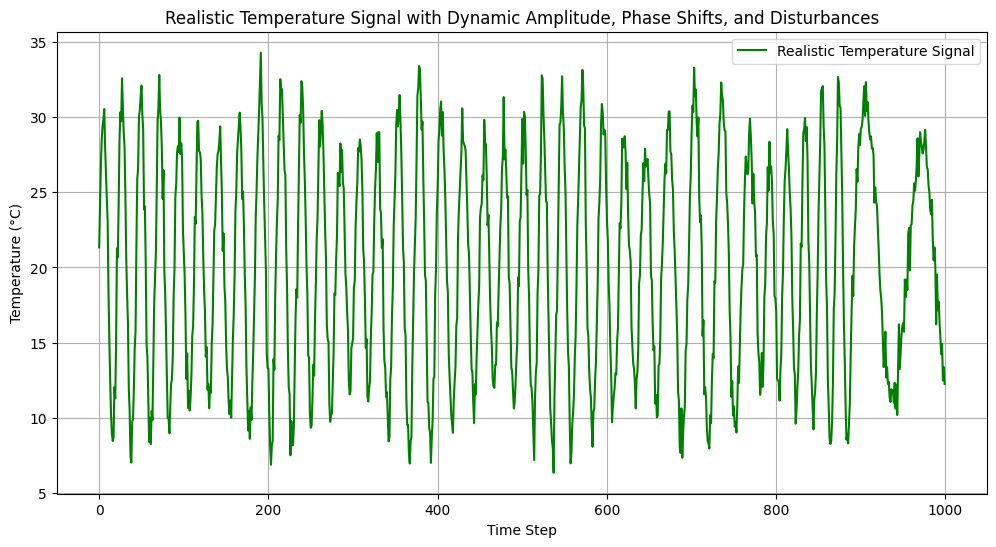

In [34]:
import numpy as np
import matplotlib.pyplot as plt

# Generate realistic temperature signal with dynamic amplitude, random phase shifts, and irregular periods
def generate_realistic_temperature_signal(total_time, time_resolution, T_avg, T_period, noise_amplitude, disturbance_probability):
    # Time points
    t = np.arange(0, total_time, time_resolution)

    # Dynamic amplitude that changes over time (weekly variation)
    amplitude_variation = 10 + 2 * np.sin(2 * np.pi * t / (7 * 24))  # Weekly amplitude variation

    # Random phase shifts (introduce variability in the start of the sine wave)
    random_phases = np.interp(t, np.linspace(0, total_time, 10), np.random.uniform(-np.pi, np.pi, 10))

    # Irregular periods (simulate variations in daily cycles)
    irregular_period = T_period + np.interp(t, np.linspace(0, total_time, 10), np.random.uniform(-2, 2, 10))
    omega = 2 * np.pi / irregular_period

    # Generate base temperature with dynamic amplitude and random phase shifts
    T_dynamic = amplitude_variation * np.sin(omega * t + random_phases) + T_avg

    # Add noise to the signal
    noise = np.random.normal(0, noise_amplitude, len(t))

    # Add occasional random disturbances (random spikes or drops in temperature)
    disturbances = np.random.choice([0, np.random.uniform(-5, 5)], size=len(t), p=[1 - disturbance_probability, disturbance_probability])

    # Combine the components: dynamic temperature, noise, and disturbances
    T_realistic = T_dynamic + noise + disturbances

    return t, T_realistic

# Parameters for the signal
total_time = 1000  # Total simulation time (in hours or time units)
time_resolution = 1  # Time step resolution (in hours or time units)
T_avg = 20  # Average temperature
T_period = 24  # Period of the temperature cycle (daily cycle, 24 hours)
noise_amplitude = 1  # Amplitude of the noise
disturbance_probability = 0.01  # Probability of a disturbance occurring at each time step

# Generate the realistic temperature signal
t, T_realistic = generate_realistic_temperature_signal(total_time, time_resolution, T_avg, T_period, noise_amplitude, disturbance_probability)

# Plot the generated temperature signal
plt.figure(figsize=(12, 6))
plt.plot(t, T_realistic, label="Realistic Temperature Signal", color='green')
plt.xlabel("Time Step")
plt.ylabel("Temperature (°C)")
plt.title("Realistic Temperature Signal with Dynamic Amplitude, Phase Shifts, and Disturbances")
plt.legend()
plt.grid(True)
plt.show()


Cumulative MSE: 40.98002675594857
Total Transmissions (Oracle): 849


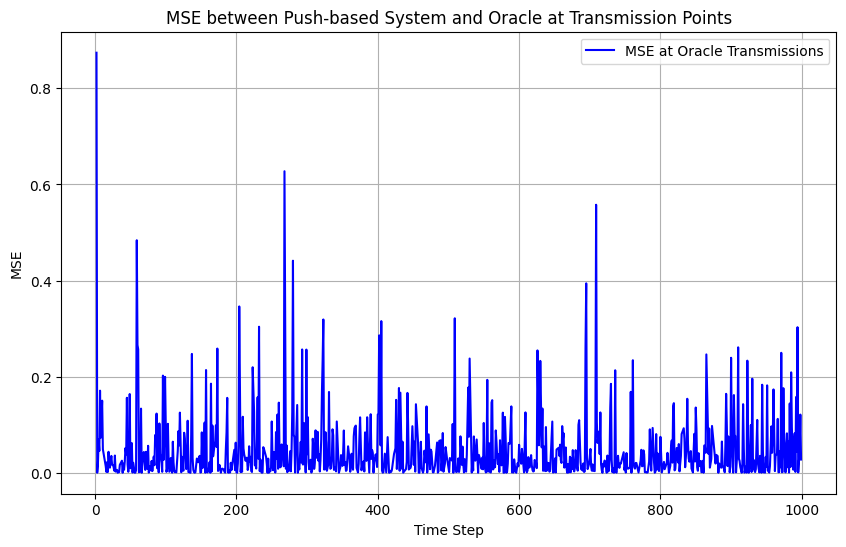

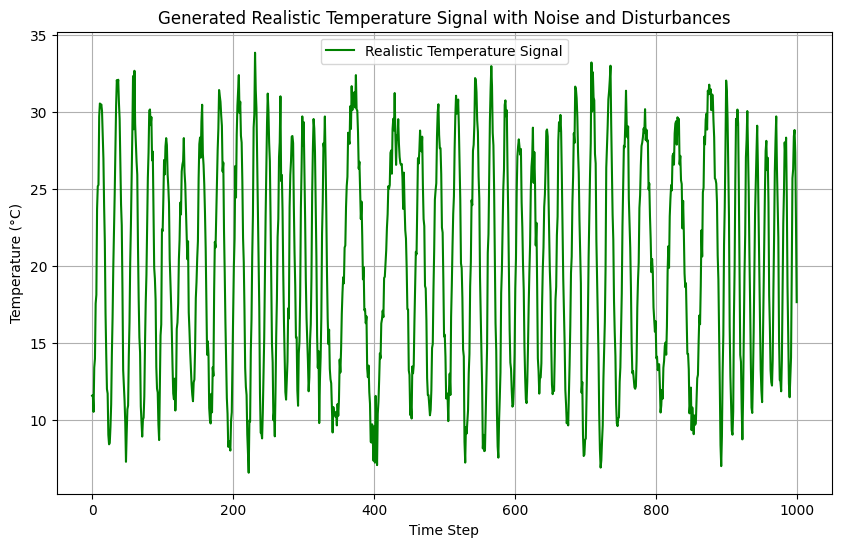

In [37]:
import numpy as np
import matplotlib.pyplot as plt

# Helper function to update state using dEWMA
def update_node_state_dewma(measured_value, last_state_value, last_rate_of_change, delta_t, beta_1, beta_2):
    x1 = beta_1 * measured_value + (1 - beta_1) * (last_state_value + last_rate_of_change * delta_t)
    x2 = beta_2 * (x1 - last_state_value) / delta_t + (1 - beta_2) * last_rate_of_change
    return x1, x2

# MSE function to compare the oracle's true value and the estimated value
def mse_between_estimate_and_true(oracle_value, estimated_value):
    return (oracle_value - estimated_value) ** 2

# Function to simulate the push-based system with VoI calculation
def push_based_system_voi(z_temp, time_steps, threshold, beta_1, beta_2, delta_t):
    last_state_value = 0
    last_rate_of_change = 0
    cumulative_mse = 0
    transmission_count = 0
    voi_mse_list = []

    # Initialize the oracle's last transmitted value
    oracle_last_transmitted_value = z_temp[0]

    for t in range(1, time_steps):
        # Update the state with dEWMA
        measured_value = z_temp[t]
        x1, x2 = update_node_state_dewma(measured_value, last_state_value, last_rate_of_change, delta_t, beta_1, beta_2)

        # Oracle decision (transmit only if VoI > threshold)
        if np.abs(z_temp[t] - oracle_last_transmitted_value) > threshold:
            oracle_transmit = 1  # Oracle transmits
            oracle_last_transmitted_value = z_temp[t]  # Update the last transmitted value

            # Capture the push-based system's estimated value at this oracle transmission point
            mse = mse_between_estimate_and_true(oracle_last_transmitted_value, x1)
            cumulative_mse += mse
            transmission_count += 1
            voi_mse_list.append((t, mse))  # Store time and MSE for analysis

        # Update the estimated state
        last_state_value = x1
        last_rate_of_change = x2

    return cumulative_mse, transmission_count, voi_mse_list

# Generate realistic temperature signal with dynamic amplitude, random phase shifts, and irregular periods
def generate_realistic_temperature_signal(total_time, time_resolution, T_avg, T_period, noise_amplitude, disturbance_probability):
    # Time points
    t = np.arange(0, total_time, time_resolution)

    # Dynamic amplitude that changes over time (weekly variation)
    amplitude_variation = 10 + 2 * np.sin(2 * np.pi * t / (7 * 24))  # Weekly amplitude variation

    # Random phase shifts (introduce variability in the start of the sine wave)
    random_phases = np.interp(t, np.linspace(0, total_time, 10), np.random.uniform(-np.pi, np.pi, 10))

    # Irregular periods (simulate variations in daily cycles)
    irregular_period = T_period + np.interp(t, np.linspace(0, total_time, 10), np.random.uniform(-2, 2, 10))
    omega = 2 * np.pi / irregular_period

    # Generate base temperature with dynamic amplitude and random phase shifts
    T_dynamic = amplitude_variation * np.sin(omega * t + random_phases) + T_avg

    # Add noise to the signal
    noise = np.random.normal(0, noise_amplitude, len(t))

    # Add occasional random disturbances (random spikes or drops in temperature)
    disturbances = np.random.choice([0, np.random.uniform(-5, 5)], size=len(t), p=[1 - disturbance_probability, disturbance_probability])

    # Combine the components: dynamic temperature, noise, and disturbances
    T_realistic = T_dynamic + noise + disturbances

    return t, T_realistic

# Parameters for the signal
total_time = 1000  # Total simulation time (in hours or time units)
time_resolution = 1  # Time step resolution (in hours or time units)
T_avg = 20  # Average temperature
T_period = 24  # Period of the temperature cycle (daily cycle, 24 hours)
noise_amplitude = 1  # Amplitude of the noise
disturbance_probability = 0.01  # Probability of a disturbance occurring at each time step

# Generate the realistic temperature signal
t, T_realistic = generate_realistic_temperature_signal(total_time, time_resolution, T_avg, T_period, noise_amplitude, disturbance_probability)

# Parameters for the push-based system
threshold = 0.5  # Threshold for VoI
beta_1 = 0.9  # dEWMA beta_1
beta_2 = 0.9  # dEWMA beta_2
delta_t = 1  # Time step for the rate of change

# Run the experiment for the push-based system with VoI calculation
cumulative_mse, transmission_count, voi_mse_list = push_based_system_voi(T_realistic, total_time, threshold, beta_1, beta_2, delta_t)

# Output Results
print(f"Cumulative MSE: {cumulative_mse}")
print(f"Total Transmissions (Oracle): {transmission_count}")

# Plot the MSE over time at the oracle's transmission points
times, mse_values = zip(*voi_mse_list)
plt.figure(figsize=(10, 6))
plt.plot(times, mse_values, label="MSE at Oracle Transmissions", color='blue')
plt.xlabel("Time Step")
plt.ylabel("MSE")
plt.title("MSE between Push-based System and Oracle at Transmission Points")
plt.legend()
plt.grid(True)

# Also plot the generated temperature signal with noise and disturbances
plt.figure(figsize=(10, 6))
plt.plot(t, T_realistic, label="Realistic Temperature Signal", color='green')
plt.xlabel("Time Step")
plt.ylabel("Temperature (°C)")
plt.title("Generated Realistic Temperature Signal with Noise and Disturbances")
plt.legend()
plt.grid(True)
plt.show()
